# Обучение и визуализация модели трансформера для генерации стихов

In [106]:
!python -V

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from datasets import load_dataset
import os

import warnings
warnings.filterwarnings('ignore')

random.seed(42)
torch.manual_seed(42)

Python 3.13.3


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [107]:
dataset = load_dataset("abobster/pushkin_new")

# Сохраняем в текстовый файл
os.makedirs("data", exist_ok=True)
with open("data/pushkin.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(dataset["train"]["text"]))

dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 19785
    })
    test: Dataset({
        features: ['text'],
        num_rows: 1974
    })
})

In [108]:
dataset['test'][0:14]

{'text': ['',
  '',
  'С позволения сказать,',
  'Я сердит на вас ужасно,',
  'Нет! — вы просите напрасно;',
  'Не хочу пера марать;',
  'Можно ль честному поэту',
  'Ставить к каждому куплету:',
  '«С позволения сказать»?',
  'С позволения сказать,',
  'Престарелые красотки,',
  'Пересчитывая четки,',
  'Станут взапуски кричать:',
  '«Это что?» — Да это скверно!']}

In [109]:
t_model_name = "sberbank-ai/rugpt3small_based_on_gpt2"
tokenizer = AutoTokenizer.from_pretrained(t_model_name)
tokenizer.pad_token = tokenizer.eos_token

In [110]:
class PushkinDataset(Dataset):
    def __init__(self, texts, tokenizer, block_size=64):
        self.examples = []
        for text in texts:
            tokens = tokenizer.encode(text, truncation=True, max_length=block_size)
            if len(tokens) > 1:
                self.examples.append(torch.tensor(tokens))

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        x = self.examples[idx][:-1]
        y = self.examples[idx][1:]
        return x, y

train_dataset = PushkinDataset(dataset["train"]["text"], tokenizer)

collate_fn = lambda batch: (
    nn.utils.rnn.pad_sequence([x for x, _ in batch], batch_first=True, padding_value=tokenizer.pad_token_id),
    nn.utils.rnn.pad_sequence([y for _, y in batch], batch_first=True, padding_value=-100)
)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)


In [111]:
# Своя простая модель трансформера с вниманием

class SimpleTransformerBlock(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=nhead, batch_first=True)
        self.ff = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Linear(dim_feedforward, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.attn_weights = None

    def forward(self, x):
        attn_output, attn_weights = self.attn(x, x, x, need_weights=True)
        self.attn_weights = attn_weights
        x = self.norm1(x + attn_output)
        x = self.norm2(x + self.ff(x))
        return x

class TransformerLM(nn.Module):
    def __init__(self, vocab_size, d_model=128, nhead=4, num_layers=2, dim_feedforward=256, max_len=512):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len, d_model))
        self.layers = nn.ModuleList([
            SimpleTransformerBlock(d_model, nhead, dim_feedforward) for _ in range(num_layers)
        ])
        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        seq_len = x.size(1)
        x = self.embedding(x) + self.pos_embedding[:, :seq_len, :]
        for layer in self.layers:
            x = layer(x)
        return self.fc_out(x)

    def get_attention(self, layer_idx):
        return self.layers[layer_idx].attn_weights


vocab_size = len(tokenizer)
model = TransformerLM(vocab_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

TransformerLM(
  (embedding): Embedding(50257, 128)
  (layers): ModuleList(
    (0-1): 2 x SimpleTransformerBlock(
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (ff): Sequential(
        (0): Linear(in_features=128, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
  )
  (fc_out): Linear(in_features=128, out_features=50257, bias=True)
)

In [141]:
m = model.to(device)
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

13.246545 M parameters


In [ ]:
EPOCHS = 20

loss_history = []
accuracy_history = []

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(ignore_index=-100)

model.train()
for epoch in range(EPOCHS):
    total_loss = 0
    total_correct = 0
    total_tokens = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits.view(-1, vocab_size), y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        preds = torch.argmax(logits, dim=-1)
        mask = (y != -100)
        correct = (preds == y) & mask
        total_correct += correct.sum().item()
        total_tokens += mask.sum().item()

    avg_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_tokens
    loss_history.append(avg_loss)
    accuracy_history.append(accuracy)
    print(f"Epoch {epoch+1}: loss = {avg_loss:.4f}, accuracy = {accuracy:.4f}")

Epoch 1: loss = 7.8121, accuracy = 0.1217
Epoch 2: loss = 5.7100, accuracy = 0.2971
Epoch 3: loss = 4.1392, accuracy = 0.4787
Epoch 4: loss = 3.0288, accuracy = 0.6124
Epoch 5: loss = 2.2667, accuracy = 0.7054
Epoch 6: loss = 1.7317, accuracy = 0.7704
Epoch 7: loss = 1.3522, accuracy = 0.8154
Epoch 8: loss = 1.0819, accuracy = 0.8450
Epoch 9: loss = 0.8806, accuracy = 0.8684
Epoch 10: loss = 0.7318, accuracy = 0.8864


Epoch 16: loss = 0.2830, accuracy = 0.9321
Epoch 17: loss = 0.2486, accuracy = 0.9375
Epoch 18: loss = 0.2153, accuracy = 0.9437
Epoch 19: loss = 0.1874, accuracy = 0.9508
Epoch 20: loss = 0.1626, accuracy = 0.9565


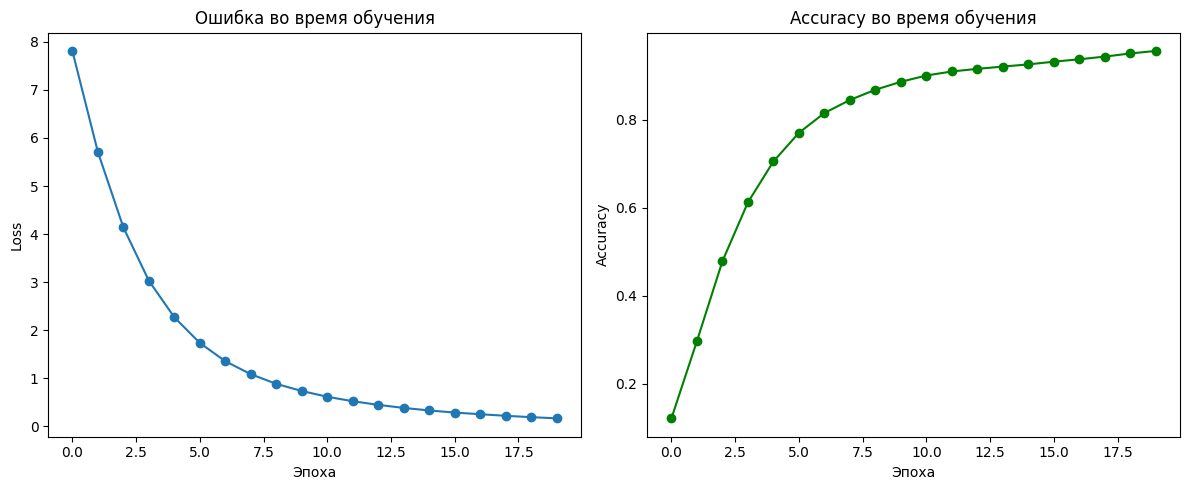

In [128]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_history, marker='o')
plt.title("Ошибка во время обучения")
plt.xlabel("Эпоха")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(accuracy_history, marker='o', color='green')
plt.title("Accuracy во время обучения")
plt.xlabel("Эпоха")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()

In [129]:
# Генерация текста по первой строчке
def generate(prompt, model, tokenizer, max_len=50):
    model.eval()
    tokens = tokenizer.encode(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        for _ in range(max_len):
            logits = model(tokens)
            next_token_logits = logits[:, -1, :]
            next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(0)
            tokens = torch.cat([tokens, next_token], dim=1)
    return tokenizer.decode(tokens[0], skip_special_tokens=True)

PROMT = "Мой дядя самых честных правил,"
generate_text = generate(PROMT, model, tokenizer)

def print_generated_text(text, words_per_line=5):
    words = text.split()
    for i in range(0, len(words), words_per_line):
        print(" ".join(words[i:i + words_per_line]))

print("\nGenerated:\n")
print_generated_text(generate_text, words_per_line=5)


Generated:

Мой дядя самых честных правил,
— он, — он он,
— он: поражает., — он
он дядя он поражает самоле,
он поражает, он спал он.,
он певец он дуракстить жены
он поражает радость он поражает
он пилитой он поражает он
темно


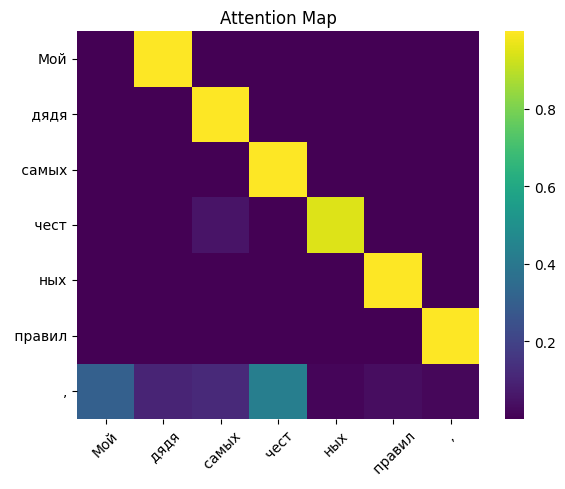

In [192]:
# Визуализация внимания
sample_input = tokenizer(PROMT, return_tensors="pt")["input_ids"].to(device)
model(sample_input)
attn_weights = model.get_attention(0)[0].detach().cpu().numpy()
tokens = tokenizer.convert_ids_to_tokens(sample_input[0])
tokens_readable = []
for i in range(len(tokens)):
    tokens_readable.append(tokenizer.convert_tokens_to_string(tokens[i:i+1]))

plt.figure(figsize=(6, 5))
sns.heatmap(attn_weights, xticklabels=tokens_readable, yticklabels=tokens_readable, cmap="viridis")
plt.title("Attention Map")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Выводы:
- Модель обучается с нуля и пытается генерировать текст в стиле оригинала.
- Диагональные полосы: это означает, что головы в основном "смотрят" на один соседний токен.
- Последние токены получают больше всего внимания от других, особенно в финальных позициях.